# Spotify Analysis Notebook

## 📋 Execution Order

**IMPORTANT**: Run cells in this order for best results:

1. **Cell 0**: Data loading (creates `df`)
2. **Cell 1-2**: CJK font configuration (for visualizations)
3. **Cell 3**: Utility functions (defines `chunk_data`, etc.)
4. **Cell 4**: Safety check for `chunk_data`
5. **Cell 5+**: Authentication and analysis cells

**Note**: If you get errors about missing variables, ensure you've run the cells in order above.

In [17]:
import pandas as pd
import glob
import numpy as np
import spotipy
import sys
import os

# Ensure the current directory is in the Python path for config import
current_dir = os.path.dirname(os.path.abspath(''))
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)

try:
    import config as cfg
except ImportError:
    # If config.py is in the same directory as the notebook, add it to path
    notebook_dir = os.getcwd()
    if notebook_dir not in sys.path:
        sys.path.insert(0, notebook_dir)
    import config as cfg

from spotipy.oauth2 import SpotifyOAuth

# Use relative paths to load json files into a list
json_files = glob.glob("./Streaming_History_Audio*.json")

if not json_files:
    raise FileNotFoundError("No JSON files found matching pattern './Streaming_History_Audio*.json'")

print(f"Found {len(json_files)} JSON file(s) to load...")

data = []

# Loop through the JSON files and read each one into a DataFrame
for i, f in enumerate(json_files, 1):
    try:
        temp_df = pd.read_json(f)
        data.append(temp_df)
        print(f"  [{i}/{len(json_files)}] Loaded {f}: {len(temp_df)} rows")
    except Exception as e:
        print(f"  Error loading {f}: {e}")
        continue

if not data:
    raise ValueError("No data was successfully loaded from JSON files")

# Concatenate all dataframes
df = pd.concat(data, ignore_index=True)
print(f"\n✓ Successfully loaded {len(df):,} total rows from {len(json_files)} file(s)")
print("\nDataFrame Info:")
df.info()


Found 9 JSON file(s) to load...
  [1/9] Loaded .\Streaming_History_Audio_2012-2014_0.json: 16617 rows
  [2/9] Loaded .\Streaming_History_Audio_2014-2015_1.json: 16418 rows
  [3/9] Loaded .\Streaming_History_Audio_2015-2016_2.json: 16334 rows
  [4/9] Loaded .\Streaming_History_Audio_2016-2017_3.json: 16212 rows
  [5/9] Loaded .\Streaming_History_Audio_2017-2019_4.json: 16340 rows
  [6/9] Loaded .\Streaming_History_Audio_2019-2020_5.json: 16416 rows
  [7/9] Loaded .\Streaming_History_Audio_2020-2021_6.json: 16086 rows
  [8/9] Loaded .\Streaming_History_Audio_2021-2022_7.json: 15856 rows
  [9/9] Loaded .\Streaming_History_Audio_2022-2023_8.json: 9294 rows

✓ Successfully loaded 139,573 total rows from 9 file(s)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139573 entries, 0 to 139572
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   ts                   

In [18]:
# Configure matplotlib to support CJK (Chinese, Japanese, Korean) characters
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

def setup_cjk_fonts():
    """Configure matplotlib to use fonts that support CJK characters"""
    system = platform.system()
    
    # Common CJK fonts on different systems
    cjk_fonts = {
        'Windows': [
            'Microsoft YaHei',  # Chinese (Simplified)
            'Microsoft JhengHei',  # Chinese (Traditional)
            'MS Gothic',  # Japanese
            'Malgun Gothic',  # Korean
            'SimHei',  # Chinese
            'SimSun',  # Chinese
        ],
        'Darwin': [  # macOS
            'PingFang SC',  # Chinese (Simplified)
            'PingFang TC',  # Chinese (Traditional)
            'Hiragino Sans GB',  # Chinese
            'Hiragino Kaku Gothic ProN',  # Japanese
            'AppleGothic',  # Korean
        ],
        'Linux': [
            'Noto Sans CJK SC',  # Chinese (Simplified)
            'Noto Sans CJK TC',  # Chinese (Traditional)
            'Noto Sans CJK JP',  # Japanese
            'Noto Sans CJK KR',  # Korean
        ]
    }
    
    # Get available fonts
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # Try to find a CJK font
    fonts_to_try = cjk_fonts.get(system, [])
    fonts_to_try.extend(['DejaVu Sans', 'Arial Unicode MS', 'Lucida Sans Unicode'])  # Fallback fonts
    
    selected_font = None
    for font in fonts_to_try:
        if font in available_fonts:
            selected_font = font
            break
    
    if selected_font:
        plt.rcParams['font.sans-serif'] = [selected_font]
        plt.rcParams['axes.unicode_minus'] = False  # Fix minus sign display
        print(f"✓ Configured matplotlib to use font: {selected_font}")
        return selected_font
    else:
        # Try to use FontProperties with a direct font file if available
        # This is a fallback method - you can specify a font file path here
        print("⚠ No CJK font found in system fonts.")
        print("  Available fonts containing 'CJK', 'Chinese', 'Japanese', or 'Korean':")
        cjk_related = [f for f in available_fonts if any(keyword in f.lower() 
                      for keyword in ['cjk', 'chinese', 'japanese', 'korean', 'yahei', 'gothic', 'simhei'])]
        if cjk_related:
            print(f"  Found: {cjk_related[:5]}")
        else:
            print("  Consider downloading a CJK font from Google Fonts (Noto Sans CJK)")
            print("  and using FontProperties with the font file path.")
        return None

# Setup CJK font support
cjk_font = setup_cjk_fonts()

✓ Configured matplotlib to use font: Microsoft YaHei


In [19]:
# Utility: Ensure common imports and check required variables
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check if df exists
if 'df' not in globals():
    raise NameError("DataFrame 'df' not found. Please run Cell 0 (data loading) first.")

# Ensure chunk_data function exists (fallback if Cell 3 wasn't run)
if 'chunk_data' not in globals():
    def chunk_data(data, chunk_size):
        """Yields successive chunk_size-sized chunks from data."""
        for i in range(0, len(data), chunk_size):
            yield data[i:i+chunk_size]

print("✓ Common imports loaded (matplotlib, seaborn, numpy)")
print("✓ DataFrame 'df' verified")
print("✓ chunk_data function available")

✓ Common imports loaded (matplotlib, seaborn, numpy)
✓ DataFrame 'df' verified
✓ chunk_data function available


In [20]:
# Alternative: Use FontProperties with a specific font file (if you have a .ttf or .otf file)
# Uncomment and modify the path below if you want to use a specific font file
# Example: Download Noto Sans CJK from Google Fonts and use it

# import matplotlib.font_manager as fm
# font_path = './fonts/NotoSansCJK-Regular.otf'  # Update this path to your font file
# cjk_font_prop = fm.FontProperties(fname=font_path)
# 
# # Then use fontproperties parameter in plot functions:
# # plt.title("标题", fontproperties=cjk_font_prop)
# # plt.xlabel("标签", fontproperties=cjk_font_prop)

# For now, we'll use the system font configured above
print("Matplotlib is now configured to display CJK characters.")

Matplotlib is now configured to display CJK characters.


In [21]:
# --- Utility Methods for Spotify Data Analysis ---
import pandas as pd
import glob
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import time

# 1. Data Loading

def load_spotify_json_data(pattern="./Streaming_History_Audio*.json"):
    """
    Loads and concatenates all JSON files matching the given pattern into a single DataFrame.
    Args:
        pattern (str): Glob pattern for JSON files.
    Returns:
        pd.DataFrame: Concatenated DataFrame of all streaming history.
    """
    json_files = glob.glob(pattern)
    data = []
    for f in json_files:
        df = pd.read_json(f)
        data.append(df)
    if data:
        return pd.concat(data, ignore_index=True)
    else:
        return pd.DataFrame()

# 2. Spotify Authentication

def get_spotify_client(client_id, client_secret, redirect_uri):
    """
    Authenticates and returns a Spotipy client using OAuth.
    Args:
        client_id (str): Spotify API client ID.
        client_secret (str): Spotify API client secret.
        redirect_uri (str): Redirect URI for Spotify API.
    Returns:
        spotipy.Spotify: Authenticated Spotify client.
    """
    return spotipy.Spotify(auth_manager=SpotifyOAuth(
        client_id=client_id,
        client_secret=client_secret,
        redirect_uri=redirect_uri
    ))

# 3. Data Cleaning

def clean_spotify_df(df):
    """
    Drops unnecessary columns and rows with missing track names.
    Args:
        df (pd.DataFrame): Raw Spotify DataFrame.
    Returns:
        pd.DataFrame: Cleaned DataFrame.
    """
    drop_cols = [
        "episode_name", "episode_show_name", "spotify_episode_uri",
        'username', 'ip_addr_decrypted', 'platform',
        'offline_timestamp', 'incognito_mode'
    ]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    df = df.dropna(subset=['master_metadata_track_name'])
    return df

# 4. Spotify API: Search Artist and Get Genres

def get_artist_genres(sp, artist_name):
    """
    Searches for an artist and returns their genres.
    Args:
        sp (spotipy.Spotify): Authenticated Spotify client.
        artist_name (str): Name of the artist to search.
    Returns:
        list: List of genres for the artist, or empty list if not found.
    """
    result = sp.search(artist_name, type='artist', limit=1)
    if result['artists']['items']:
        artist = result['artists']['items'][0]
        artist_info = sp.artist(artist['id'])
        return artist_info.get('genres', [])
    return []

# 5. Chunking Utility (for batch API calls)

def chunk_data(data, chunk_size):
    """
    Yields successive chunk_size-sized chunks from data.
    Args:
        data (iterable): Data to chunk.
        chunk_size (int): Size of each chunk.
    Yields:
        list: Chunk of data.
    """
    for i in range(0, len(data), chunk_size):
        yield data[i:i+chunk_size]

# Utility function to check required variables
def check_required_vars(required_vars):
    """Check if required variables exist in global scope"""
    missing = [var for var in required_vars if var not in globals()]
    if missing:
        raise NameError(f"Required variables not found: {missing}. Please run the appropriate setup cells first.")
    return True

# 6. Rate Limiting for API Calls

def make_api_call_limited(calls_made, window_start_time, max_calls=50, time_window=30):
    """
    Checks and enforces API rate limits.
    Args:
        calls_made (int): Number of calls made in the current window.
        window_start_time (float): Start time of the current window.
        max_calls (int): Max calls per window.
        time_window (int): Window duration in seconds.
    Returns:
        (bool, int, float): (Can make call, updated calls_made, updated window_start_time)
    """
    current_time = time.time()
    if current_time - window_start_time > time_window:
        window_start_time = current_time
        calls_made = 0
    if calls_made < max_calls:
        calls_made += 1
        return True, calls_made, window_start_time
    else:
        return False, calls_made, window_start_time

# --- End Utility Methods ---


In [22]:
# Safety check: Ensure chunk_data is available
# This ensures chunk_data is defined even if Cell 3 wasn't run
if 'chunk_data' not in globals():
    def chunk_data(data, chunk_size):
        """Yields successive chunk_size-sized chunks from data."""
        for i in range(0, len(data), chunk_size):
            yield data[i:i+chunk_size]
    print("✓ chunk_data function defined (fallback)")
else:
    print("✓ chunk_data function already available")

✓ chunk_data function already available


# How to Use the Utility Methods

- Use `load_spotify_json_data()` to load your streaming history into a DataFrame.
- Use `get_spotify_client()` to authenticate with Spotify.
- Use `clean_spotify_df()` to clean your DataFrame.
- Use `get_artist_genres()` to look up genres for an artist.
- Use `chunk_data()` for batching API calls.

Below, the notebook is refactored to use these methods for clarity and reusability.

In [23]:
# Load, clean, and authenticate using utility methods
import config as cfg

# Load all streaming history JSON files into a DataFrame
df = load_spotify_json_data()

# Clean the DataFrame by dropping unnecessary columns and nulls
df = clean_spotify_df(df)

# Authenticate with Spotify using credentials from config.py
sp = get_spotify_client(
    client_id=cfg.spotify['client_id'],
    client_secret=cfg.spotify['client_secret'],
    redirect_uri=cfg.spotify['redirect_uri']
)

# Show info about the cleaned DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139339 entries, 0 to 139572
Data columns (total 13 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   ts                                 139339 non-null  object
 1   ms_played                          139339 non-null  int64 
 2   conn_country                       139339 non-null  object
 3   user_agent_decrypted               138032 non-null  object
 4   master_metadata_track_name         139339 non-null  object
 5   master_metadata_album_artist_name  139339 non-null  object
 6   master_metadata_album_album_name   139339 non-null  object
 7   spotify_track_uri                  139339 non-null  object
 8   reason_start                       139339 non-null  object
 9   reason_end                         139339 non-null  object
 10  shuffle                            139339 non-null  bool  
 11  skipped                            52800 non-null   

# Exploratory Data Analysis (EDA)

In this section, we use the cleaned DataFrame to explore null values, unique values, and perform basic data analysis. All steps use the utility methods and variables defined above for clarity and reusability.

In [24]:
# Check for null values in each column
df.isnull().sum()

# Show DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139339 entries, 0 to 139572
Data columns (total 13 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   ts                                 139339 non-null  object
 1   ms_played                          139339 non-null  int64 
 2   conn_country                       139339 non-null  object
 3   user_agent_decrypted               138032 non-null  object
 4   master_metadata_track_name         139339 non-null  object
 5   master_metadata_album_artist_name  139339 non-null  object
 6   master_metadata_album_album_name   139339 non-null  object
 7   spotify_track_uri                  139339 non-null  object
 8   reason_start                       139339 non-null  object
 9   reason_end                         139339 non-null  object
 10  shuffle                            139339 non-null  bool  
 11  skipped                            52800 non-null   

## 403 Error Diagnosis

If you're getting a 403 Forbidden error when fetching audio features, it's usually due to:

1. **Expired Access Token** - Most common cause. Re-authenticate by re-running the cell that creates `sp`
2. **Invalid Credentials** - Check your `config.py` file has correct client_id and client_secret
3. **Missing Scopes** - Audio features endpoint usually doesn't need special scopes, but verify your app settings

**Quick Fix**: Re-run the authentication cell (the one with `sp = spotipy.Spotify(...)`)

In [25]:
# DIAGNOSTIC: Test Spotify API connection
print("Testing Spotify API connection...")
try:
    # Try a simple API call to test authentication
    test_result = sp.current_user()
    print(f"✓ Authentication successful! Logged in as: {test_result.get('display_name', 'User')}")
    print(f"  User ID: {test_result.get('id', 'N/A')}")
except Exception as e:
    error_msg = str(e)
    if '403' in error_msg or 'Forbidden' in error_msg:
        print("❌ 403 Forbidden - Authentication failed!")
        print("\nPossible causes:")
        print("  1. Access token expired - Re-run the authentication cell")
        print("  2. Invalid credentials in config.py")
        print("  3. App not properly configured in Spotify Developer Dashboard")
        print("\nSOLUTION: Re-run the cell that creates 'sp' (Spotify client)")
    elif '401' in error_msg:
        print("❌ 401 Unauthorized - Invalid or expired token")
        print("SOLUTION: Re-authenticate by re-running the authentication cell")
    else:
        print(f"❌ Error: {e}")
    raise

Testing Spotify API connection...
✓ Authentication successful! Logged in as: Mahmuud Ibrahim
  User ID: 1246157207


In [26]:
# IMPROVED: Batch fetch audio features with error handling
# First, check if features.json already exists
import os
import time

# Check required variables
if 'df' not in globals():
    raise NameError("DataFrame 'df' not found. Please run Cell 0 (data loading) first.")
if 'sp' not in globals():
    raise NameError("Spotify client 'sp' not found. Please run the authentication cell first.")
if 'chunk_data' not in globals():
    raise NameError("Function 'chunk_data' not found. Please run Cell 3 (utility functions) first.")

if os.path.exists('./features.json'):
    print("✓ Found existing features.json file. Loading from file...")
    features_df = pd.read_json('./features.json')
    print(f"Loaded {len(features_df)} audio features from file.")
    print("If you need to refresh the data, delete features.json and re-run this cell.")
else:
    print("No features.json found. Fetching from Spotify API...")
    print()
    
    features_list = []
    chunk_size = 50  # Adjust based on API rate limits
    unique_tracks = df['spotify_track_uri'].dropna().unique()
    total_chunks = (len(unique_tracks) + chunk_size - 1) // chunk_size
    
    print(f"Fetching audio features for {len(unique_tracks)} unique tracks in {total_chunks} batches...")
    
    for i, chunk in enumerate(chunk_data(unique_tracks, chunk_size), 1):
        try:
            # Extract track IDs from URIs
            track_ids = [uri.split(':')[-1] if ':' in uri else uri for uri in chunk]
            
            batch_features = sp.audio_features(track_ids)
            
            if batch_features:
                # Filter out None values (tracks that don't have features)
                valid_features = [f for f in batch_features if f is not None]
                features_list.extend(valid_features)
                print(f"  Batch {i}/{total_chunks}: Retrieved {len(valid_features)}/{len(chunk)} features")
            else:
                print(f"  Batch {i}/{total_chunks}: No features returned")
            
            # Rate limiting delay
            if i < total_chunks:
                time.sleep(0.1)
                
        except Exception as e:
            error_msg = str(e)
            if '403' in error_msg or 'Forbidden' in error_msg:
                print(f"\n❌ 403 Forbidden Error on batch {i}")
                print("   DIAGNOSIS:")
                print("   - Your access token has likely expired")
                print("   - OR your Spotify app credentials are invalid")
                print("\n   SOLUTION:")
                print("   1. Re-run the authentication cell (creates 'sp' variable)")
                print("   2. If that doesn't work, check your config.py credentials")
                print("   3. Verify your app in Spotify Developer Dashboard")
                raise
            elif '429' in error_msg or 'rate limit' in error_msg.lower():
                wait_time = 10
                print(f"  ⚠ Rate limited on batch {i}. Waiting {wait_time} seconds...")
                time.sleep(wait_time)
                # Retry this batch
                i -= 1
                continue
            else:
                print(f"  ⚠ Error on batch {i}: {e}")
                # Continue with next batch
                continue
    
    if features_list:
        features_df = pd.DataFrame(features_list)
        # Save to file for future use
        features_df.to_json('./features.json', orient='records', indent=2)
        print(f"\n✓ Successfully fetched and saved {len(features_df)} audio features to features.json")
    else:
        raise ValueError("No audio features were retrieved. Check your authentication.")

print(f"\nFeatures DataFrame shape: {features_df.shape}")
features_df.head()

✓ Found existing features.json file. Loading from file...
Loaded 25722 audio features from file.
If you need to refresh the data, delete features.json and re-run this cell.

Features DataFrame shape: (25722, 18)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.722,0.976,1,-3.546,1,0.1770,0.0829,0.000000,0.372,0.757,129.910,audio_features,3eMfBkKz0ZuffMqIVHhNr1,spotify:track:3eMfBkKz0ZuffMqIVHhNr1,https://api.spotify.com/v1/tracks/3eMfBkKz0Zuf...,https://api.spotify.com/v1/audio-analysis/3eMf...,240107,4
1,0.827,0.966,1,-2.917,1,0.1510,0.0863,0.000000,0.799,0.720,144.078,audio_features,44eZ0RG3gWBfiD5o9pvIV9,spotify:track:44eZ0RG3gWBfiD5o9pvIV9,https://api.spotify.com/v1/tracks/44eZ0RG3gWBf...,https://api.spotify.com/v1/audio-analysis/44eZ...,261453,4
2,0.676,0.748,10,-5.369,0,0.4880,0.0441,0.000000,0.897,0.529,140.045,audio_features,0uQWGMWQAtpISoXTEi5as6,spotify:track:0uQWGMWQAtpISoXTEi5as6,https://api.spotify.com/v1/tracks/0uQWGMWQAtpI...,https://api.spotify.com/v1/audio-analysis/0uQW...,150693,4
3,0.671,0.711,2,-7.813,1,0.0478,0.4220,0.000000,0.104,0.466,113.809,audio_features,45Zo6ftGzq6wRckCUrMoBJ,spotify:track:45Zo6ftGzq6wRckCUrMoBJ,https://api.spotify.com/v1/tracks/45Zo6ftGzq6w...,https://api.spotify.com/v1/audio-analysis/45Zo...,248440,4
4,0.563,0.865,5,-5.277,1,0.1600,0.0472,0.000191,0.770,0.601,156.271,audio_features,6b7TVeW6F7YLK1ZHDb2VA1,spotify:track:6b7TVeW6F7YLK1ZHDb2VA1,https://api.spotify.com/v1/tracks/6b7TVeW6F7YL...,https://api.spotify.com/v1/audio-analysis/6b7T...,209413,4


In [27]:
# Show unique values for key columns
print('Unique artists:', df['master_metadata_album_artist_name'].nunique())
print('Unique tracks:', df['master_metadata_track_name'].nunique())
print('Unique countries:', df['conn_country'].nunique())
print('Unique start reasons:', df['reason_start'].unique())
print('Unique end reasons:', df['reason_end'].unique())

Unique artists: 6186
Unique tracks: 20669
Unique countries: 7
Unique start reasons: ['' 'trackdone' 'backbtn' 'fwdbtn' 'unknown' 'popup' 'clickrow' 'uriopen'
 'playbtn' 'appload' 'remote' 'trackerror' 'clickside' 'endplay']
Unique end reasons: ['' 'trackdone' 'backbtn' 'fwdbtn' 'endplay' 'unknown' 'popup' 'clickrow'
 'uriopen' 'remote' 'clickside' 'appload' 'trackerror' 'logout'
 'unexpected-exit-while-paused' 'unexpected-exit']


In [28]:
# Example: Get genres for a specific artist using the utility method
artist_name = 'Microwave'  # Replace with any artist name of interest
genres = get_artist_genres(sp, artist_name)
print(f"Genres for {artist_name}: {genres}")

Genres for Microwave: ['midwest emo', 'emo', 'pop punk']


In [32]:
# Should succeed if your token/app is valid
sp.me()["id"]                # requires user auth (OAuth) with user-read-email or similar
sp.track("3eMfBkKz0ZuffMqIVHhNr1")["name"]  # should succeed with app auth OR user auth


'Kill Shit'

In [33]:
token_info = sp.auth_manager.get_cached_token()
print(token_info.keys())
print("scopes:", token_info.get("scope"))
print("expires_at:", token_info.get("expires_at"))


dict_keys(['access_token', 'token_type', 'expires_in', 'expires_at', 'scope', 'refresh_token'])
scopes: None
expires_at: 1768502683


In [34]:
try:
    print(sp.audio_features(["3eMfBkKz0ZuffMqIVHhNr1"]))
except Exception as e:
    print(type(e), e)


HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3eMfBkKz0ZuffMqIVHhNr1 with Params: {} returned 403 due to None


<class 'spotipy.exceptions.SpotifyException'> http status: 403, code:-1 - https://api.spotify.com/v1/audio-features/?ids=3eMfBkKz0ZuffMqIVHhNr1:
 None, reason: None


In [31]:
# Example: Batch fetch audio features for unique track URIs using chunk_data
features_list = []
chunk_size = 50  # Adjust based on API rate limits
for chunk in chunk_data(df['spotify_track_uri'].dropna().unique(), chunk_size):
    batch_features = sp.audio_features(chunk)
    features_list.extend(batch_features)

# Convert the list of features into a DataFrame
features_df = pd.DataFrame(features_list)
features_df.head()

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=3eMfBkKz0ZuffMqIVHhNr1,44eZ0RG3gWBfiD5o9pvIV9,0uQWGMWQAtpISoXTEi5as6,45Zo6ftGzq6wRckCUrMoBJ,6b7TVeW6F7YLK1ZHDb2VA1,44SNh4cxnJPTbT03o4H5qy,7r2tLINapK54V3oPmwfq06,6wwRcy6fL6ZhDnBJY4ZrZN,54wdG7MEGhtkhLsxprlltp,143WOUk29w9r44CHmpRVB9,1Co8j9Scb43e1zhXBUzjKm,2oBvncOkOTaxmTbOkmgGGw,1zvjTusTVWseney5P81L1c,5ipOo1CD7gAwzKAMEXUBp9,1xT1D2IXxgDVc8TQCp8PhS,4mKlzy0qaK1c2Qw5e2VqpF,0tTItrFFKMtk6KIJ1hBhiz,6M3tbJcqQDOrTE9EbataIr,236KjQgQQMQ05RXFz4jYbf,5z4Mdwll7mqiRKXNlbgyz6,773GlfTf841YG0H8UHAdaP,5Tj8Ch41ZjgP4w8wq2bp87,1DeCY9A335xThtQG9dIswN,4UREBi0OLmnYCArzVENqfn,4Y5EjgH7XOE0ejrVGQ8nzW,3PbsDnKdrZY0ttX7VE9s5R,0agBriTy7L5vFjeFT4qXr9,1595LW73XBxkRk2ciQOHfr,0Fc8hmAuH0rHYq2Ur9t07Y,0VnLohgzwLEleLmo19Z8B0,69igAjKIJC7Plk3VIRe5Pp,1oVlMEQe8myOjNCASaAHnQ,0FY4Kh2ovEnMruf5LRcVW9,0grFc6klR3hxoHLcgCYsF4,6MT0NNylqer37ZrkRfyXMf,1XSGGUy9BmF9PcsGpJBg5x,1hVGgHJ5KMuIpgQ9pU9Op6,6LOUewO73zxwqxPNUldUuK,3tA4mUVj6YHuKEFoIP2Pnf,6a2XGmn3DsrmAZYVafMKQi,2osItBrdIRT

SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/audio-features/?ids=3eMfBkKz0ZuffMqIVHhNr1,44eZ0RG3gWBfiD5o9pvIV9,0uQWGMWQAtpISoXTEi5as6,45Zo6ftGzq6wRckCUrMoBJ,6b7TVeW6F7YLK1ZHDb2VA1,44SNh4cxnJPTbT03o4H5qy,7r2tLINapK54V3oPmwfq06,6wwRcy6fL6ZhDnBJY4ZrZN,54wdG7MEGhtkhLsxprlltp,143WOUk29w9r44CHmpRVB9,1Co8j9Scb43e1zhXBUzjKm,2oBvncOkOTaxmTbOkmgGGw,1zvjTusTVWseney5P81L1c,5ipOo1CD7gAwzKAMEXUBp9,1xT1D2IXxgDVc8TQCp8PhS,4mKlzy0qaK1c2Qw5e2VqpF,0tTItrFFKMtk6KIJ1hBhiz,6M3tbJcqQDOrTE9EbataIr,236KjQgQQMQ05RXFz4jYbf,5z4Mdwll7mqiRKXNlbgyz6,773GlfTf841YG0H8UHAdaP,5Tj8Ch41ZjgP4w8wq2bp87,1DeCY9A335xThtQG9dIswN,4UREBi0OLmnYCArzVENqfn,4Y5EjgH7XOE0ejrVGQ8nzW,3PbsDnKdrZY0ttX7VE9s5R,0agBriTy7L5vFjeFT4qXr9,1595LW73XBxkRk2ciQOHfr,0Fc8hmAuH0rHYq2Ur9t07Y,0VnLohgzwLEleLmo19Z8B0,69igAjKIJC7Plk3VIRe5Pp,1oVlMEQe8myOjNCASaAHnQ,0FY4Kh2ovEnMruf5LRcVW9,0grFc6klR3hxoHLcgCYsF4,6MT0NNylqer37ZrkRfyXMf,1XSGGUy9BmF9PcsGpJBg5x,1hVGgHJ5KMuIpgQ9pU9Op6,6LOUewO73zxwqxPNUldUuK,3tA4mUVj6YHuKEFoIP2Pnf,6a2XGmn3DsrmAZYVafMKQi,2osItBrdIRTMOkAuY14wLm,741kfDIxlYdlTTZi59JDvM,1Wj7EAtDKUuvPvtfySEn5L,13vmjHzY9GrzmD9O7vNzPy,3BlY0jB9TmzzyyD07OTcLf,7cObcW7HAwo1IBDCFyrNB9,5l6uNdJtz9djEFKcZ3iB9a,3vt8c6QBGPmbaVcydiMQAC,00FtsAob2Pw986hLy6hnpO,5eBFZkklgqSHeqCABthpXq:
 None, reason: None

In [ ]:
# Merge audio features with main DataFrame on track URI
df = df.merge(features_df, how='left', left_on='spotify_track_uri', right_on='uri')
df.head()

# Visualization and Analysis

Now that the DataFrame is cleaned and enriched with audio features, we can proceed with various analyses and visualizations, such as distribution plots, groupings, and artist/song statistics.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Plot distribution of seconds played
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='seconds_played', bins=100, kde=True)
plt.title('Distribution of Seconds Played for All Songs')
plt.xlabel('Seconds Played')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Calculate total hours played per song
if 'hours_played' not in df.columns:
    df['hours_played'] = df['ms_played'] / (1000*60*60)
top_songs = df.groupby('master_metadata_track_name')['hours_played'].sum().sort_values(ascending=False).head(25)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_songs.values, y=top_songs.index, palette='viridis')
plt.title('Top 25 Most Listened Songs by Total Hours Played')
plt.xlabel('Total Hours Played')
plt.ylabel('Song')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate total hours played per artist
top_artists = df.groupby('master_metadata_album_artist_name')['hours_played'].sum().sort_values(ascending=False).head(25)

plt.figure(figsize=(14, 8))
sns.barplot(x=top_artists.values, y=top_artists.index, palette='magma')
plt.title('Top 25 Most Listened Artists by Total Hours Played')
plt.xlabel('Total Hours Played')
plt.ylabel('Artist')
plt.tight_layout()
plt.show()

In [ ]:
# Violin plots for continuous variables
continuous_vars = df.select_dtypes(include=['float64', 'int64']).columns
sns.set(style="whitegrid")
for var in continuous_vars:
    plt.figure(figsize=(8, 2))
    sns.violinplot(x=df[var])
    plt.title(f'Violin plot of {var}')
    plt.show()

# Summary and Next Steps

This notebook has been refactored for clarity and reusability using utility methods for data loading, cleaning, Spotify API access, and chunking. You can now easily extend the analysis, add new visualizations, or build models using the clean and enriched DataFrame.

- To analyze more features, simply call the utility methods as needed.
- For advanced modeling or recommendations, continue from here using the processed data.

In [ ]:
#hide your login information
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id = cfg.spotify['client_id'], client_secret =cfg.spotify['client_secret'], redirect_uri = cfg.spotify['redirect_uri'] ))

Exploratory Data Analysis

In [ ]:
# exploring null values by column
df.isnull().sum() 

ts                                        0
username                                  0
platform                                  0
ms_played                                 0
conn_country                              0
ip_addr_decrypted                         0
user_agent_decrypted                   1310
master_metadata_track_name              234
master_metadata_album_artist_name       234
master_metadata_album_album_name        234
spotify_track_uri                       234
episode_name                         139529
episode_show_name                    139529
spotify_episode_uri                  139529
reason_start                              0
reason_end                                0
shuffle                                   0
skipped                               86581
offline                                   0
offline_timestamp                         0
incognito_mode                            0
dtype: int64

In [ ]:
df = df.drop(columns=["episode_name","episode_show_name","spotify_episode_uri",'username','ip_addr_decrypted','platform','offline_timestamp','incognito_mode'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139573 entries, 0 to 9293
Data columns (total 13 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   ts                                 139573 non-null  object
 1   ms_played                          139573 non-null  int64 
 2   conn_country                       139573 non-null  object
 3   user_agent_decrypted               138263 non-null  object
 4   master_metadata_track_name         139339 non-null  object
 5   master_metadata_album_artist_name  139339 non-null  object
 6   master_metadata_album_album_name   139339 non-null  object
 7   spotify_track_uri                  139339 non-null  object
 8   reason_start                       139573 non-null  object
 9   reason_end                         139573 non-null  object
 10  shuffle                            139573 non-null  bool  
 11  skipped                            52992 non-null   ob

In [ ]:
df.isnull().sum()

ts                                       0
ms_played                                0
conn_country                             0
user_agent_decrypted                  1310
master_metadata_track_name             234
master_metadata_album_artist_name      234
master_metadata_album_album_name       234
spotify_track_uri                      234
reason_start                             0
reason_end                               0
shuffle                                  0
skipped                              86581
offline                                  0
dtype: int64

In [ ]:
df.dropna(subset=['master_metadata_track_name'], inplace=True)

In [ ]:
df.isnull().sum()

ts                                       0
ms_played                                0
conn_country                             0
user_agent_decrypted                  1307
master_metadata_track_name               0
master_metadata_album_artist_name        0
master_metadata_album_album_name         0
spotify_track_uri                        0
reason_start                             0
reason_end                               0
shuffle                                  0
skipped                              86539
offline                                  0
dtype: int64

In [ ]:
acount = df['master_metadata_album_artist_name'].unique()
acount.size

6186

In [ ]:
result = sp.search("Microwave")
track = result['tracks']['items'][0]

artist = sp.artist(track["artists"][0]["external_urls"]["spotify"])
print("artist genres:", artist["genres"])


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139339 entries, 0 to 9293
Data columns (total 13 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   ts                                 139339 non-null  object
 1   ms_played                          139339 non-null  int64 
 2   conn_country                       139339 non-null  object
 3   user_agent_decrypted               138032 non-null  object
 4   master_metadata_track_name         139339 non-null  object
 5   master_metadata_album_artist_name  139339 non-null  object
 6   master_metadata_album_album_name   139339 non-null  object
 7   spotify_track_uri                  139339 non-null  object
 8   reason_start                       139339 non-null  object
 9   reason_end                         139339 non-null  object
 10  shuffle                            139339 non-null  bool  
 11  skipped                            52800 non-null   ob

In [ ]:
df['conn_country'].unique()

array(['US', 'ZZ', 'GD', 'QA', 'ET', 'CA', 'AU'], dtype=object)

In [ ]:
df["reason_start"].unique()

array(['', 'trackdone', 'backbtn', 'fwdbtn', 'unknown', 'popup',
       'clickrow', 'uriopen', 'playbtn', 'appload', 'remote',
       'trackerror', 'clickside', 'endplay'], dtype=object)

In [ ]:
df["reason_end"].unique()

array(['', 'trackdone', 'backbtn', 'fwdbtn', 'endplay', 'unknown',
       'popup', 'clickrow', 'uriopen', 'remote', 'clickside', 'appload',
       'trackerror', 'logout', 'unexpected-exit-while-paused',
       'unexpected-exit'], dtype=object)

In [ ]:
df['skipped'].unique()

array([True, False, nan], dtype=object)

In [ ]:
df['user_agent_decrypted'].unique()

array(['unknown',
       'Mozilla%2f5.0%20(Windows%20NT%206.2%3b%20rv%3a22.0)%20Gecko%2f20100101%20Firefox%2f22.0',
       'Mozilla%2f5.0%20(Windows%20NT%2010.0%3b%20WOW64%3b%20rv%3a49.0)%20Gecko%2f20100101%20Firefox%2f49.0',
       'Mozilla%2F5.0%20(Windows%20NT%2010.0;%20WOW64;%20rv:56.0)%20Gecko%2F20100101%20Firefox%2F56.0',
       'Mozilla%2F5.0%20(Windows%20NT%2010.0;%20WOW64;%20rv:57.0)%20Gecko%2F20100101%20Firefox%2F57.0',
       'Mozilla%2F5.0%20(Windows%20NT%2010.0;%20WOW64;%20rv:66.0)%20Gecko%2F20100101%20Firefox%2F66.0',
       'Mozilla%2F5.0%20(X11;%20Linux%20aarch64)%20AppleWebKit%2F537.36%20(KHTML,%20like%20Gecko)%20Chrome%2F76.0.3809.81%20Safari%2F537.36%20CrKey%2F1.42.172094',
       'Mozilla%2F5.0%20(X11;%20Linux%20aarch64)%20AppleWebKit%2F537.36%20(KHTML,%20like%20Gecko)%20Chrome%2F76.0.3809.81%20Safari%2F537.36%20CrKey%2F1.42.183786',
       '51642384', '55640155', '55312411',
       'Mozilla%2F5.0%20(X11;%20Linux%20armv7l)%20AppleWebKit%2F537.36%20(KHTML,%20like%20G

In [ ]:
skipped = df.loc[df['skipped'] == True]

skipped

,ts,ms_played,conn_country,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,shuffle,skipped,offline
0,2012-08-31T17:21:11Z,21966,US,unknown,Kill Shit,Krizz Kaliko,Kickin' & Screamin',spotify:track:3eMfBkKz0ZuffMqIVHhNr1,,,False,True,False
2,2012-08-31T17:31:17Z,59112,US,unknown,Dumb For You,Krizz Kaliko,Kickin' & Screamin',spotify:track:0uQWGMWQAtpISoXTEi5as6,trackdone,backbtn,False,True,False
4,2012-08-31T17:36:17Z,22923,US,unknown,Dumb For You,Krizz Kaliko,Kickin' & Screamin',spotify:track:0uQWGMWQAtpISoXTEi5as6,trackdone,backbtn,False,True,False
5,2012-08-31T17:36:52Z,35387,US,unknown,Mayday,Krizz Kaliko,Kickin' & Screamin',spotify:track:44eZ0RG3gWBfiD5o9pvIV9,backbtn,,False,True,False
6,2012-08-31T17:39:34Z,160172,US,unknown,Under Pressure - Remastered 2011,Queen,Queen 40 Limited Edition Collector's Box Set V...,spotify:track:45Zo6ftGzq6wRckCUrMoBJ,,,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9288,2023-07-31T21:18:18Z,806,US,unknown,But Why Would You Care?,Knuckle Puck,While I Stay Secluded,spotify:track:3ub5KhKyPgGROItcZgQf1o,trackdone,endplay,False,1.0,False
9289,2023-07-31T21:18:24Z,5210,US,unknown,Vampire,Brooklane,Vampire,spotify:track:6ljnm3mEA1vzcRjwydZonk,playbtn,endplay,False,1.0,False
9290,2023-07-31T21:18:26Z,1540,US,unknown,Catalina Fight Song,Joyce Manor,Never Hungover Again,spotify:track:2TqfK2N1kFoX7OySPCB7pQ,clickrow,endplay,False,1.0,False
9291,2023-07-31T21:18:27Z,1050,US,unknown,What's Up?,Mom Jeans.,Sweet Tooth,spotify:track:141alNiSd9vG4Lb22BLHWM,clickrow,endplay,False,1.0,False


In [ ]:
skipped.describe()

,ms_played
count,2.245500e+04
mean,3.818303e+04
std,6.455642e+04
min,0.000000e+00
25%,2.368000e+03
50%,5.979000e+03
75%,4.569150e+04
max,1.432510e+06


In [ ]:
df.describe()

,ms_played
count,1.393390e+05
mean,1.385504e+05
std,1.007533e+05
min,0.000000e+00
25%,1.676050e+04
50%,1.731030e+05
75%,2.136960e+05
max,1.432510e+06


In [ ]:
df['seconds_played'] = df['ms_played'] / 1000

In [ ]:
df

,ts,ms_played,conn_country,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,shuffle,skipped,offline,seconds_played
0,2012-08-31T17:21:11Z,21966,US,unknown,Kill Shit,Krizz Kaliko,Kickin' & Screamin',spotify:track:3eMfBkKz0ZuffMqIVHhNr1,,,False,True,False,21.966
1,2012-08-31T17:30:20Z,454489,US,unknown,Mayday,Krizz Kaliko,Kickin' & Screamin',spotify:track:44eZ0RG3gWBfiD5o9pvIV9,,trackdone,False,False,False,454.489
2,2012-08-31T17:31:17Z,59112,US,unknown,Dumb For You,Krizz Kaliko,Kickin' & Screamin',spotify:track:0uQWGMWQAtpISoXTEi5as6,trackdone,backbtn,False,True,False,59.112
3,2012-08-31T17:35:54Z,261453,US,unknown,Mayday,Krizz Kaliko,Kickin' & Screamin',spotify:track:44eZ0RG3gWBfiD5o9pvIV9,backbtn,trackdone,False,False,False,261.453
4,2012-08-31T17:36:17Z,22923,US,unknown,Dumb For You,Krizz Kaliko,Kickin' & Screamin',spotify:track:0uQWGMWQAtpISoXTEi5as6,trackdone,backbtn,False,True,False,22.923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9289,2023-07-31T21:18:24Z,5210,US,unknown,Vampire,Brooklane,Vampire,spotify:track:6ljnm3mEA1vzcRjwydZonk,playbtn,endplay,False,1.0,False,5.210
9290,2023-07-31T21:18:26Z,1540,US,unknown,Catalina Fight Song,Joyce Manor,Never Hungover Again,spotify:track:2TqfK2N1kFoX7OySPCB7pQ,clickrow,endplay,False,1.0,False,1.540
9291,2023-07-31T21:18:27Z,1050,US,unknown,What's Up?,Mom Jeans.,Sweet Tooth,spotify:track:141alNiSd9vG4Lb22BLHWM,clickrow,endplay,False,1.0,False,1.050
9292,2023-07-31T21:18:33Z,6950,US,unknown,"Thinking of You,",Microwave,Split,spotify:track:0wWtrTfTPmdT41WzzvCjhc,clickrow,endplay,False,1.0,False,6.950


In [ ]:
df.describe()

,ms_played,seconds_played
count,1.393390e+05,139339.000000
mean,1.385504e+05,138.550416
std,1.007533e+05,100.753319
min,0.000000e+00,0.000000
25%,1.676050e+04,16.760500
50%,1.731030e+05,173.103000
75%,2.136960e+05,213.696000
max,1.432510e+06,1432.510000


In [ ]:
df['hours_played'] = df['ms_played'] / (1000*60*60)
total_hours_per_song = pd.DataFrame(df.groupby('master_metadata_track_name')['hours_played'].sum().reset_index())
total_hours_per_artist = pd.DataFrame(df.groupby('master_metadata_album_artist_name')['hours_played'].sum().reset_index())
total_hours_per_song.sort_values('hours_played',ascending=True)

,master_metadata_track_name,hours_played
4890,Dum Ditty Dumb,0.000000
16387,Ten Times,0.000000
9925,Life in a Northern Town,0.000000
1252,Architechs of Discotech - John B Remix,0.000000
1251,Architechs of Discotech,0.000000
...,...,...
13979,Roses,9.311264
5204,Everybody,9.889828
7786,Hurricane,10.340605
2868,Came Out Swinging,10.575498


In [ ]:
for column in df:
    print(df[column].unique())

def chunk_data(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i+chunk_size]
        
chunk_size = 10

def chunk_data(data, chunk_size):
    for i in range(0, len(data), chunk_size):
        yield data[i:i+chunk_size]

# Define chunk size
chunk_size = 50  # You may adjust this based on the rate limit and your needs

# Create an empty list to store the features
features_list = []

# Chunk the unique track IDs into batches
for chunk in chunk_data(df['spotify_track_uri'].unique(), chunk_size):
    # Get audio features for the current chunk of track IDs
    batch_features = sp.audio_features(chunk)
    # Append the batch features to the features list
    features_list.extend(batch_features)

# Convert the list of features into a DataFrame
features = pd.DataFrame(features_list)

# Now 'features' DataFrame should contain the audio features for all tracks
print(features)

import time

genres = {}
album_ids = []

# Define chunk size
chunk_size = 3

# Define rate limiting parameters
MAX_CALLS = 50
TIME_WINDOW = 30
calls_made = 0
window_start_time = time.time()

def make_api_call():
    global calls_made, window_start_time
    current_time = time.time()

    # Check if the current time window has elapsed
    if current_time - window_start_time > TIME_WINDOW:
        window_start_time = current_time
        calls_made = 0

    # Check if the number of API calls is within the limit
    if calls_made < MAX_CALLS:
        calls_made += 1
        return True
    else:
        return False

def process_artist(artist_name):
    if not make_api_call():
        print("API call not made - rate limit exceeded")
        return

    # Search for the artist on Spotify
    result = sp.search(artist_name, type='artist', limit=1)
    if result['artists']['items']:
        artist = result['artists']['items'][0]
        artist_url = artist['external_urls']['spotify']

        # Retrieve the artist's genres
        artist_info = sp.artist(artist_url)
        genres[artist_name] = artist_info['genres']

        # Optionally collect album IDs from the artist's top tracks
        top_tracks = sp.artist_top_tracks(artist_url)
        for track in top_tracks['tracks']:
            album_ids.append(track['album']['id'])

# Remove duplicates and chunk album IDs for batch processing
album_ids = list(set(album_ids))

# Splitting the artist names into chunks for processing
for chunk in chunk_data(df['master_metadata_album_artist_name'].unique(), chunk_size):
    for artist_name in chunk:
        process_artist(artist_name)
        time.sleep(1)  # Simulate some delay between API calls


album_info = {}

# Fetch album details in batches
for chunk in chunk_data(album_ids, 20):  # Smaller batch size due to potential API constraints
    albums = sp.albums(chunk)
    for album in albums['albums']:
        album_info[album['id']] = {
            'name': album['name'],
            'release_date': album['release_date'],
            'genres': album['genres']  # Not all album responses include genres
        }

print("Genres:", genres)
print("Album Info:", album_info)

In [ ]:
features =pd.read_json("./features.json")

In [ ]:
df = df.merge(features, how='left', left_on='spotify_track_uri', right_on='uri')

# Group by the distinct entries and sum up the duration values
result = df.groupby('spotify_track_uri')['duration_ms'].sum().reset_index()

# Print the result
result

,spotify_track_uri,duration_ms
0,spotify:track:002AzLaJtX4Tyi7Yv0J49w,420758
1,spotify:track:003FTlCpBTM4eSqYSWPv4H,4665340
2,spotify:track:003vvx7Niy0yvhvHt4a68B,222973
3,spotify:track:004VU4cWTkRqVMrlv8KW3D,1145600
4,spotify:track:0054onP0Kw05Ws8rrhkIlx,1754230
...,...,...
25717,spotify:track:7zu033uK8PfJ0lqOIKHhzL,2002290
25718,spotify:track:7zulua0I1rbhbStBxJFuno,510456
25719,spotify:track:7zweZVDWIMvQIC6bDsEtcL,1325718
25720,spotify:track:7zx0r1pcEiX92UwJ3MuNbV,444028


In [ ]:
df

,ts,ms_played,conn_country,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,2012-08-31T17:21:11Z,21966,US,unknown,Kill Shit,Krizz Kaliko,Kickin' & Screamin',spotify:track:3eMfBkKz0ZuffMqIVHhNr1,,,...,0.372,0.7570,129.910,audio_features,3eMfBkKz0ZuffMqIVHhNr1,spotify:track:3eMfBkKz0ZuffMqIVHhNr1,https://api.spotify.com/v1/tracks/3eMfBkKz0Zuf...,https://api.spotify.com/v1/audio-analysis/3eMf...,240107,4
1,2012-08-31T17:30:20Z,454489,US,unknown,Mayday,Krizz Kaliko,Kickin' & Screamin',spotify:track:44eZ0RG3gWBfiD5o9pvIV9,,trackdone,...,0.799,0.7200,144.078,audio_features,44eZ0RG3gWBfiD5o9pvIV9,spotify:track:44eZ0RG3gWBfiD5o9pvIV9,https://api.spotify.com/v1/tracks/44eZ0RG3gWBf...,https://api.spotify.com/v1/audio-analysis/44eZ...,261453,4
2,2012-08-31T17:31:17Z,59112,US,unknown,Dumb For You,Krizz Kaliko,Kickin' & Screamin',spotify:track:0uQWGMWQAtpISoXTEi5as6,trackdone,backbtn,...,0.897,0.5290,140.045,audio_features,0uQWGMWQAtpISoXTEi5as6,spotify:track:0uQWGMWQAtpISoXTEi5as6,https://api.spotify.com/v1/tracks/0uQWGMWQAtpI...,https://api.spotify.com/v1/audio-analysis/0uQW...,150693,4
3,2012-08-31T17:35:54Z,261453,US,unknown,Mayday,Krizz Kaliko,Kickin' & Screamin',spotify:track:44eZ0RG3gWBfiD5o9pvIV9,backbtn,trackdone,...,0.799,0.7200,144.078,audio_features,44eZ0RG3gWBfiD5o9pvIV9,spotify:track:44eZ0RG3gWBfiD5o9pvIV9,https://api.spotify.com/v1/tracks/44eZ0RG3gWBf...,https://api.spotify.com/v1/audio-analysis/44eZ...,261453,4
4,2012-08-31T17:36:17Z,22923,US,unknown,Dumb For You,Krizz Kaliko,Kickin' & Screamin',spotify:track:0uQWGMWQAtpISoXTEi5as6,trackdone,backbtn,...,0.897,0.5290,140.045,audio_features,0uQWGMWQAtpISoXTEi5as6,spotify:track:0uQWGMWQAtpISoXTEi5as6,https://api.spotify.com/v1/tracks/0uQWGMWQAtpI...,https://api.spotify.com/v1/audio-analysis/0uQW...,150693,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139334,2023-07-31T21:18:24Z,5210,US,unknown,Vampire,Brooklane,Vampire,spotify:track:6ljnm3mEA1vzcRjwydZonk,playbtn,endplay,...,0.545,0.2690,145.053,audio_features,6ljnm3mEA1vzcRjwydZonk,spotify:track:6ljnm3mEA1vzcRjwydZonk,https://api.spotify.com/v1/tracks/6ljnm3mEA1vz...,https://api.spotify.com/v1/audio-analysis/6ljn...,205405,4
139335,2023-07-31T21:18:26Z,1540,US,unknown,Catalina Fight Song,Joyce Manor,Never Hungover Again,spotify:track:2TqfK2N1kFoX7OySPCB7pQ,clickrow,endplay,...,0.103,0.3490,107.655,audio_features,2TqfK2N1kFoX7OySPCB7pQ,spotify:track:2TqfK2N1kFoX7OySPCB7pQ,https://api.spotify.com/v1/tracks/2TqfK2N1kFoX...,https://api.spotify.com/v1/audio-analysis/2Tqf...,65000,4
139336,2023-07-31T21:18:27Z,1050,US,unknown,What's Up?,Mom Jeans.,Sweet Tooth,spotify:track:141alNiSd9vG4Lb22BLHWM,clickrow,endplay,...,0.274,0.8280,84.488,audio_features,141alNiSd9vG4Lb22BLHWM,spotify:track:141alNiSd9vG4Lb22BLHWM,https://api.spotify.com/v1/tracks/141alNiSd9vG...,https://api.spotify.com/v1/audio-analysis/141a...,141909,4
139337,2023-07-31T21:18:33Z,6950,US,unknown,"Thinking of You,",Microwave,Split,spotify:track:0wWtrTfTPmdT41WzzvCjhc,clickrow,endplay,...,0.145,0.0684,75.018,audio_features,0wWtrTfTPmdT41WzzvCjhc,spotify:track:0wWtrTfTPmdT41WzzvCjhc,https://api.spotify.com/v1/tracks/0wWtrTfTPmdT...,https://api.spotify.com/v1/audio-analysis/0wWt...,278065,4


In [ ]:
# Group by the distinct entries and sum up the duration values
duration= df.groupby('spotify_track_uri')['duration_ms'].sum().reset_index()

# Print the result
duration

,spotify_track_uri,duration_ms
0,spotify:track:002AzLaJtX4Tyi7Yv0J49w,420758
1,spotify:track:003FTlCpBTM4eSqYSWPv4H,4665340
2,spotify:track:003vvx7Niy0yvhvHt4a68B,222973
3,spotify:track:004VU4cWTkRqVMrlv8KW3D,1145600
4,spotify:track:0054onP0Kw05Ws8rrhkIlx,1754230
...,...,...
25717,spotify:track:7zu033uK8PfJ0lqOIKHhzL,2002290
25718,spotify:track:7zulua0I1rbhbStBxJFuno,510456
25719,spotify:track:7zweZVDWIMvQIC6bDsEtcL,1325718
25720,spotify:track:7zx0r1pcEiX92UwJ3MuNbV,444028


In [ ]:
duration.sort_values('duration_ms',ascending=True)

,spotify_track_uri,duration_ms
22870,spotify:track:6vFdbKRrTCjpXOtrT1jMzL,3056
9941,spotify:track:308tF31YwyZcSyDwzcAd4W,4512
1800,spotify:track:0YvIMzVJiRGogOZqBL2lBV,5000
24585,spotify:track:7eExy5rCxu550jjyoHSoTN,6693
21437,spotify:track:6V3GWmZ1dRPwXcm4LBuCki,6706
...,...,...
3579,spotify:track:15FlkvOEu8iFCBPZ64heHJ,39070619
15032,spotify:track:4X8VB7lmL7o4QiypDYmqaA,42228788
10005,spotify:track:31fhbuLXa8S7QUMLupVRW4,42983452
15862,spotify:track:4mVzCmTZeBOkvSQsuvFQWh,47480530


In [ ]:
# Group by the distinct entries and sum up the duration values
secPlay = df.groupby('spotify_track_uri')['seconds_played'].sum().reset_index()

# Print the result
secPlay

,spotify_track_uri,seconds_played
0,spotify:track:002AzLaJtX4Tyi7Yv0J49w,228.373
1,spotify:track:003FTlCpBTM4eSqYSWPv4H,1763.224
2,spotify:track:003vvx7Niy0yvhvHt4a68B,222.973
3,spotify:track:004VU4cWTkRqVMrlv8KW3D,87.095
4,spotify:track:0054onP0Kw05Ws8rrhkIlx,1392.940
...,...,...
25717,spotify:track:7zu033uK8PfJ0lqOIKHhzL,1747.671
25718,spotify:track:7zulua0I1rbhbStBxJFuno,510.021
25719,spotify:track:7zweZVDWIMvQIC6bDsEtcL,1117.603
25720,spotify:track:7zx0r1pcEiX92UwJ3MuNbV,84.360


In [ ]:
secPlay.sort_values('seconds_played',ascending=True)

,spotify_track_uri,seconds_played
12985,spotify:track:3vZO25GdYuqFrR1kzZADnp,0.000
16713,spotify:track:524dNa5OJEhKlXOuLBbUl6,0.000
16201,spotify:track:4sUoWHVnJl8z3t4zdqf6xB,0.000
7206,spotify:track:2B47iGiXHXnL7W1BOgMnRW,0.000
21315,spotify:track:6SWHTMywuTXLFlMQ75cAuu,0.000
...,...,...
15052,spotify:track:4XTJFHSPamFmR6Xs6rM0kD,27175.136
10005,spotify:track:31fhbuLXa8S7QUMLupVRW4,28348.904
3579,spotify:track:15FlkvOEu8iFCBPZ64heHJ,31352.045
15862,spotify:track:4mVzCmTZeBOkvSQsuvFQWh,35560.780


In [ ]:
df.sort_values(by=['seconds_played'])

,ts,ms_played,conn_country,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
55385,2017-02-09T02:35:05Z,0,US,unknown,Back To Back,Drake,Back To Back,spotify:track:5lFDtgWsjRJu8fPOAyJIAK,fwdbtn,fwdbtn,...,0.116,0.382,86.976,audio_features,5lFDtgWsjRJu8fPOAyJIAK,spotify:track:5lFDtgWsjRJu8fPOAyJIAK,https://api.spotify.com/v1/tracks/5lFDtgWsjRJu...,https://api.spotify.com/v1/audio-analysis/5lFD...,170638,4
8946,2014-04-29T19:40:41Z,0,US,unknown,House of Gold,Twenty One Pilots,Vessel,spotify:track:36tghkPg1AO4HsAzo6YpPp,appload,appload,...,0.208,0.851,114.948,audio_features,36tghkPg1AO4HsAzo6YpPp,spotify:track:36tghkPg1AO4HsAzo6YpPp,https://api.spotify.com/v1/tracks/36tghkPg1AO4...,https://api.spotify.com/v1/audio-analysis/36tg...,163880,4
29632,2015-03-25T12:42:42Z,0,US,unknown,Truffle Butter,Nicki Minaj,Truffle Butter,spotify:track:3keUgTGEoZJt0QkzTB6kHg,fwdbtn,fwdbtn,...,0.124,0.491,105.113,audio_features,3keUgTGEoZJt0QkzTB6kHg,spotify:track:3keUgTGEoZJt0QkzTB6kHg,https://api.spotify.com/v1/tracks/3keUgTGEoZJt...,https://api.spotify.com/v1/audio-analysis/3keU...,219227,4
16661,2014-09-30T14:54:32Z,0,US,unknown,Girl All the Bad Guys Want,Bowling For Soup,Girls Gone Wild Music: Volume 1,spotify:track:0l81LQsw3UjSZ7dc5Qspfw,fwdbtn,fwdbtn,...,0.162,0.856,130.976,audio_features,0l81LQsw3UjSZ7dc5Qspfw,spotify:track:0l81LQsw3UjSZ7dc5Qspfw,https://api.spotify.com/v1/tracks/0l81LQsw3UjS...,https://api.spotify.com/v1/audio-analysis/0l81...,197373,4
102865,2020-09-14T12:51:52Z,0,US,unknown,君はヒーローになれる,Yuki Hayashi,TVアニメ『僕のヒーローアカデミア』オリジナル・サウンドトラック,spotify:track:1Cdz1ehTv3zCKqmGbPI2Vo,trackdone,endplay,...,0.096,0.169,91.969,audio_features,1Cdz1ehTv3zCKqmGbPI2Vo,spotify:track:1Cdz1ehTv3zCKqmGbPI2Vo,https://api.spotify.com/v1/tracks/1Cdz1ehTv3zC...,https://api.spotify.com/v1/audio-analysis/1Cdz...,176053,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24921,2015-01-14T03:46:17Z,937872,US,unknown,Order of the Court,Matt Braunger,Don't Tell My Mother!,spotify:track:4AVqcdwaFwF3z2jgdXHm0l,appload,trackdone,...,0.846,0.517,63.926,audio_features,4AVqcdwaFwF3z2jgdXHm0l,spotify:track:4AVqcdwaFwF3z2jgdXHm0l,https://api.spotify.com/v1/tracks/4AVqcdwaFwF3...,https://api.spotify.com/v1/audio-analysis/4AVq...,937872,3
5353,2014-03-07T04:09:23Z,1119653,US,unknown,Sober Vegan Party Time,Jamie Kilstein,What Alive People Do,spotify:track:5J2tbBcaunqxKR13g9jsaL,trackdone,trackdone,...,0.881,0.531,72.861,audio_features,5J2tbBcaunqxKR13g9jsaL,spotify:track:5J2tbBcaunqxKR13g9jsaL,https://api.spotify.com/v1/tracks/5J2tbBcaunqx...,https://api.spotify.com/v1/audio-analysis/5J2t...,1119653,3
5359,2014-03-07T04:53:04Z,1287053,US,unknown,Two Sad Stories,Jamie Kilstein,What Alive People Do,spotify:track:5PI1hgonu5ypz1DfqSafgC,trackdone,trackdone,...,0.955,0.540,98.526,audio_features,5PI1hgonu5ypz1DfqSafgC,spotify:track:5PI1hgonu5ypz1DfqSafgC,https://api.spotify.com/v1/tracks/5PI1hgonu5yp...,https://api.spotify.com/v1/audio-analysis/5PI1...,1287053,4
114455,2021-09-09T18:24:16Z,1335094,US,unknown,I Just Want To Sell Out My Funeral,The Wonder Years,The Greatest Generation,spotify:track:332ir2EcItlNDEju0vj61P,clickrow,trackdone,...,0.374,0.307,114.897,audio_features,332ir2EcItlNDEju0vj61P,spotify:track:332ir2EcItlNDEju0vj61P,https://api.spotify.com/v1/tracks/332ir2EcItlN...,https://api.spotify.com/v1/audio-analysis/332i...,454817,4


In [ ]:
df.info()
df['time_signature'].unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139339 entries, 0 to 139338
Columns: 142 entries, ts to time_signature
dtypes: bool(2), float64(65), int64(29), object(46)
memory usage: 150.2+ MB


array([4, 3, 5, 1, 0], dtype=int64)

<Axes: xlabel='key', ylabel='time_signature'>

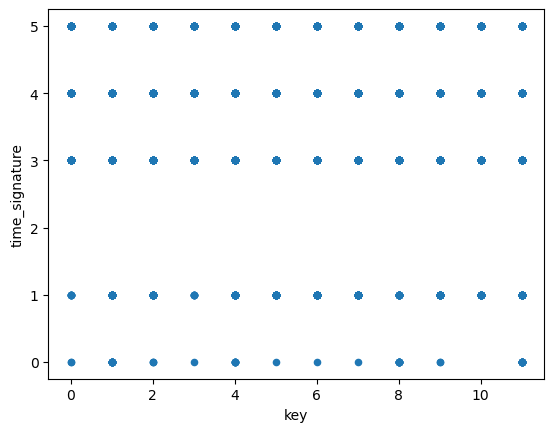

In [ ]:
df.plot.scatter(x='key',y='time_signature')

<Axes: xlabel='key', ylabel='acousticness'>

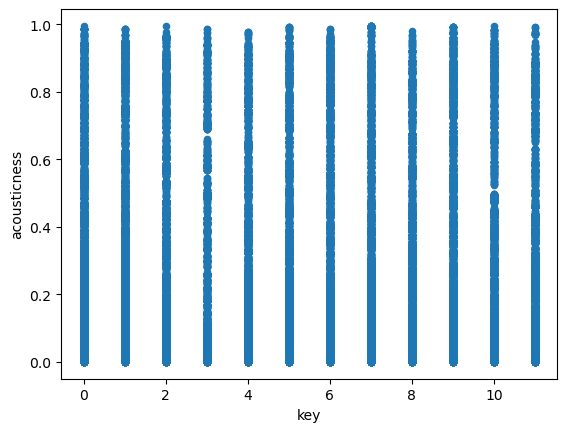

In [ ]:
df.plot.scatter(x='key',y='acousticness')

<Axes: xlabel='key', ylabel='energy'>

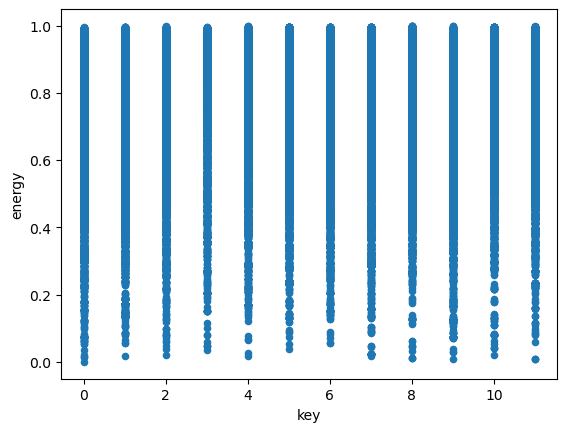

In [ ]:
df.plot.scatter(x='key',y='energy')

<Axes: xlabel='key', ylabel='liveness'>

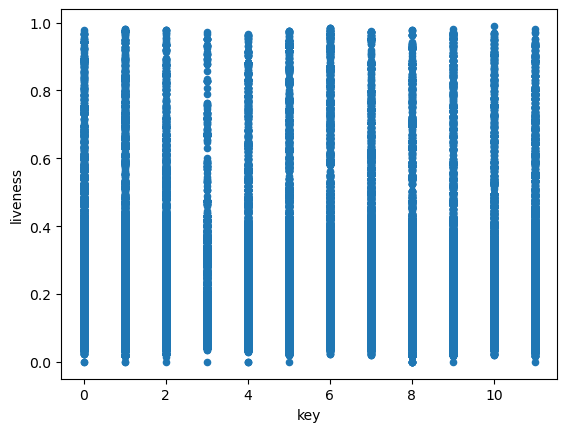

In [ ]:
df.plot.scatter(x='key', y='liveness')

<Axes: xlabel='key', ylabel='speechiness'>

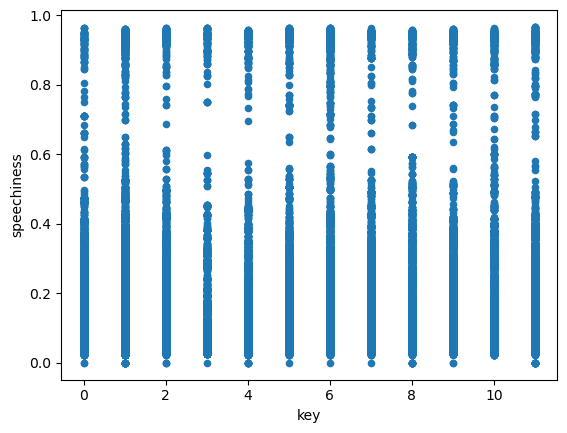

In [ ]:
df.plot.scatter(x='key',y='speechiness')

<Axes: xlabel='key', ylabel='danceability'>

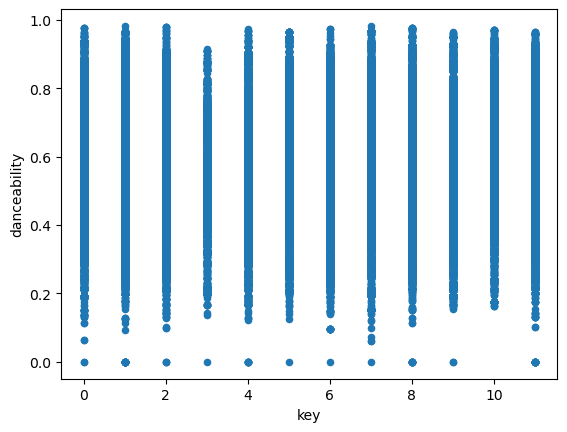

In [ ]:
df.plot.scatter(x='key',y='danceability')

<Axes: xlabel='key', ylabel='duration_ms'>

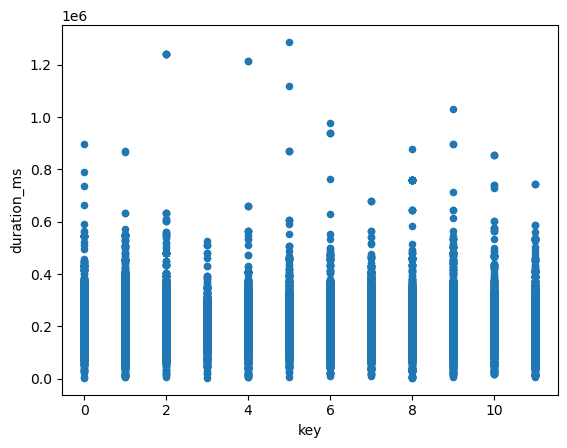

In [ ]:
df.plot.scatter(x='key',y='duration_ms')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
listen_threshold = 30
df['listen_status'] = df['seconds_played'] >= listen_threshold
plt.figure(figsize=(10, 6))
sns.histplot(data=df[df['listen_status']], x='seconds_played', bins=100, kde=True)
plt.title('Distribution of Seconds Played for Listened Songs')
plt.xlabel('Seconds Played')
plt.ylabel('Frequency')
plt.show()

In [ ]:
sns.histplot(data=result,x='seconds_played', bins = 100, kde = True)
plt.title('Distribution of Total listen time per uri')
plt.show()

In [ ]:
plt.boxplot(df['seconds_played'])
plt.show

In [ ]:
sorted_data = np.sort(df['seconds_played'])
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
cdf_df = pd.DataFrame({'Seconds Played': sorted_data, 'CDF': cdf})
plt.plot(cdf_df['Seconds Played'], cdf_df['CDF'], marker='.', linestyle='none')
plt.xlabel('Seconds Played')
plt.ylabel('CDF')
plt.title('CDF of Seconds Played')
plt.grid()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table to count unique combinations of start and end reasons
pivot_df = df.pivot_table(index='reason_start', columns='reason_end', aggfunc='size', fill_value=0)

# Create the heatmap with custom scaling and tick labels
plt.figure(figsize=(12,8))
sns.heatmap(pivot_df, annot=True, fmt='d', cmap='YlGnBu', vmin=0, vmax=pivot_df.values.max())

# Set custom tick labels
plt.title('Start and End Reasons Categorized')
plt.xlabel('End Reason')
plt.ylabel('Start Reason')
plt.xticks(ticks=np.arange(len(pivot_df.columns)), labels=pivot_df.columns, rotation=45)
plt.yticks(ticks=np.arange(len(pivot_df.index)), labels=pivot_df.index)

plt.show()


In [ ]:
continuous_vars = df.select_dtypes(include=['float64', 'int64']).columns

# Plotting
sns.set(style="whitegrid")
for var in continuous_vars:
    sns.violinplot(x=df[var])
    plt.title(f'Violin plot of {var}')
    plt.show()

In [ ]:
top25 = df[df['seconds_played'] > df['seconds_played'].quantile(.75)]
top25

In [ ]:
top25.describe()

In [ ]:
# Calculate usage rates
skip_rate = df['skipped'].value_counts(normalize=True) * 100
shuffle_rate = df['shuffle'].value_counts(normalize=True) * 100

# Create pie charts
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].pie(skip_rate, labels=skip_rate.index, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
axes[0].set_title('Skip Usage Rate')
axes[1].pie(shuffle_rate, labels=shuffle_rate.index, autopct='%1.1f%%', colors=['gold', 'lightgreen'])
axes[1].set_title('Shuffle Usage Rate')
plt.tight_layout()
plt.show()


In [ ]:
# Convert 'ts' to datetime, ensuring timezone is retained
df['ts'] = pd.to_datetime(df['ts'])

# Group data by year-month directly without converting to Periods
# This method retains timezone information
df['year_month'] = df['ts'].dt.strftime('%Y-%m')
stream_count_by_month = df.groupby('year_month').size()

# Create a line plot
plt.figure(figsize=(12, 6))
stream_count_by_month.plot(kind='line')
plt.title('Number of Streams Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Streams')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [ ]:
# Get the top 50 most listened songs
top_songs = df['master_metadata_track_name'].value_counts().head(50)

# Create a bar plot for top songs
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")
sns.barplot(x=top_songs.values, y=top_songs.index, palette='viridis')

# Add title and labels
plt.title('Top 50 Most Listened Songs')
plt.xlabel('Number of Plays')
plt.ylabel('Song')

# Rotate song labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
plt.figure(figsize=(25, 12))
top_artists = total_hours_per_artist.sort_values('hours_played', ascending=False).head(75)
sns.barplot(x='hours_played', y='master_metadata_album_artist_name', data=top_artists, palette='viridis')
plt.title('Top 75 Artists by Total Listening Hours')
plt.xlabel('Total Hours Listened')
plt.ylabel('Artist Name')
plt.show()

In [ ]:
# Create a new column combining song name and artist name
df['song_artist'] = df['master_metadata_track_name'] + ' - ' + df['master_metadata_album_artist_name']

# Get the top 50 most listened songs
top_songs = df['song_artist'].value_counts().head(50)

# Create a bar plot for top songs
plt.figure(figsize=(25,12))
sns.set(style="whitegrid")
sns.barplot(x=top_songs.values, y=top_songs.index, palette='viridis')

# Add title and labels
plt.title('Top 50 Most Listened Songs')
plt.xlabel('Number of Plays')
plt.ylabel('Song - Artist')

# Rotate song labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust the layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


NameError: name 'plt' is not defined

In [ ]:
top_songs = df['song_artist'].value_counts().head(50)
plt.figure(figsize=(25, 12))
sns.barplot(x=top_songs.values, y=top_songs.index, palette='viridis')
plt.title('Top 75 Songs by Total Listening Hours')
plt.xlabel('Total Hours Listened')
plt.ylabel('Song Name')
plt.show()

In [ ]:
hurricane = df.loc[df['master_metadata_track_name'] == 'Hurricane']
hurricane['master_metadata_album_artist_name'].unique()

In [ ]:
df.describe()

In [ ]:
# Calculate weighted audio features (weighted by listening time)
audio_features_weighted = ['danceability', 'energy', 'valence', 'acousticness', 
                           'instrumentalness', 'liveness', 'speechiness', 'tempo']

# Create weighted averages for each audio feature
for feature in audio_features_weighted:
    df[f'{feature}_weighted'] = df[feature] * df['hours_played']

# Calculate overall weighted averages
weighted_avg_features = {}
for feature in audio_features_weighted:
    weighted_avg_features[feature] = df[f'{feature}_weighted'].sum() / df['hours_played'].sum()

print("Overall Weighted Average Audio Features (by listening time):")
for feature, value in weighted_avg_features.items():
    print(f"{feature}: {value:.4f}")

In [ ]:
# Audio features over time
df['year'] = df['ts'].dt.year
df['month'] = df['ts'].dt.month

# Group by year-month and calculate weighted averages
def weighted_avg(group):
    """Calculate weighted average for audio features"""
    total_hours = group['hours_played'].sum()
    if total_hours == 0:
        return pd.Series({
            'danceability': 0, 'energy': 0, 'valence': 0, 'acousticness': 0,
            'hours_played': 0
        })
    return pd.Series({
        'danceability': (group['danceability'] * group['hours_played']).sum() / total_hours,
        'energy': (group['energy'] * group['hours_played']).sum() / total_hours,
        'valence': (group['valence'] * group['hours_played']).sum() / total_hours,
        'acousticness': (group['acousticness'] * group['hours_played']).sum() / total_hours,
        'hours_played': total_hours
    })

monthly_features = df.groupby('year_month').apply(weighted_avg).reset_index()

# Plot audio features over time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

features_to_plot = ['danceability', 'energy', 'valence', 'acousticness']
for idx, feature in enumerate(features_to_plot):
    axes[idx].plot(monthly_features['year_month'], monthly_features[feature], marker='o', linewidth=2)
    axes[idx].set_title(f'{feature.capitalize()} Over Time')
    axes[idx].set_xlabel('Year-Month')
    axes[idx].set_ylabel(f'{feature.capitalize()}')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Correlation heatmap of audio features
audio_feature_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                      'speechiness', 'acousticness', 'instrumentalness', 
                      'liveness', 'valence', 'tempo', 'hours_played', 'seconds_played']

correlation_matrix = df[audio_feature_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Audio Features Correlation Heatmap')
plt.tight_layout()
plt.show()

# Time-Based Insights

In [ ]:
# Extract time components
df['hour'] = df['ts'].dt.hour
df['day_of_week'] = df['ts'].dt.day_name()
df['day_of_month'] = df['ts'].dt.day
df['week'] = df['ts'].dt.isocalendar().week

# Listening patterns by hour of day
hourly_listening = df.groupby('hour')['hours_played'].sum().reset_index()

plt.figure(figsize=(14, 6))
sns.barplot(x='hour', y='hours_played', data=hourly_listening, palette='viridis')
plt.title('Total Listening Hours by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Total Hours Listened')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
# Listening patterns by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

daily_listening = df.groupby('day_of_week')['hours_played'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='hours_played', data=daily_listening, palette='mako')
plt.title('Total Listening Hours by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Hours Listened')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
# Heatmap: Hour of Day vs Day of Week
hour_day_heatmap = df.groupby(['day_of_week', 'hour'])['hours_played'].sum().reset_index()
hour_day_pivot = hour_day_heatmap.pivot(index='day_of_week', columns='hour', values='hours_played')
hour_day_pivot = hour_day_pivot.reindex(day_order)

plt.figure(figsize=(20, 8))
sns.heatmap(hour_day_pivot, annot=False, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Hours Listened'})
plt.title('Listening Patterns: Day of Week vs Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

In [ ]:
# Listening trends by year
yearly_listening = df.groupby('year').agg({
    'hours_played': 'sum',
    'master_metadata_track_name': 'nunique',
    'master_metadata_album_artist_name': 'nunique'
}).reset_index()
yearly_listening.columns = ['year', 'total_hours', 'unique_tracks', 'unique_artists']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(yearly_listening['year'], yearly_listening['total_hours'], color='skyblue')
axes[0].set_title('Total Listening Hours by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Hours')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(yearly_listening['year'], yearly_listening['unique_tracks'], color='lightcoral')
axes[1].set_title('Unique Tracks by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Unique Tracks')
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(yearly_listening['year'], yearly_listening['unique_artists'], color='lightgreen')
axes[2].set_title('Unique Artists by Year')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Number of Unique Artists')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Genre Analysis

# Improved Genre Fetching (Rate Limit Friendly)

In [ ]:
# IMPROVED: Fetch genres using batch artists() endpoint instead of search()
# This is much more efficient and avoids rate limits
import time

def get_artist_genres_efficient(df_data, sp_client, top_n=100, chunk_size=50, delay=0.2):
    """
    Fetch genres using artist IDs from track data.
    Uses batch artists() endpoint (50 artists per call) instead of search() (1 per call).
    
    This reduces API calls from 100 to just 2-3 calls for 100 artists!
    """
    genres_dict = {}
    
    # Get top artists
    top_artists = df_data['master_metadata_album_artist_name'].value_counts().head(top_n)
    top_artist_names = top_artists.index.tolist()
    
    print(f"Step 1: Extracting artist IDs from track data for {len(top_artist_names)} artists...")
    
    # Extract artist IDs from existing track URIs
    artist_name_to_id = {}
    processed_tracks = set()
    
    for artist_name in top_artist_names:
        if artist_name in artist_name_to_id:
            continue
            
        # Get first track for this artist
        artist_tracks = df_data[df_data['master_metadata_album_artist_name'] == artist_name]
        if len(artist_tracks) == 0:
            continue
            
        track_uri = artist_tracks.iloc[0]['spotify_track_uri']
        track_id = track_uri.split(':')[-1]
        
        if track_id in processed_tracks:
            continue
        processed_tracks.add(track_id)
        
        try:
            track_info = sp_client.track(track_id)
            if track_info and track_info['artists']:
                for artist in track_info['artists']:
                    if artist['name'] == artist_name:
                        artist_name_to_id[artist_name] = artist['id']
                        break
        except Exception as e:
            if '429' in str(e):
                print(f"Rate limited. Waiting 5 seconds...")
                time.sleep(5)
            continue
        
        time.sleep(delay)
    
    print(f"Step 2: Found {len(artist_name_to_id)} artist IDs. Fetching genres in batches...")
    
    # Use batch artists() endpoint - this is the key improvement!
    artist_ids = list(artist_name_to_id.values())
    artist_names_list = list(artist_name_to_id.keys())
    
    for i in range(0, len(artist_ids), chunk_size):
        batch_ids = artist_ids[i:i+chunk_size]
        batch_names = artist_names_list[i:i+chunk_size]
        
        try:
            # Batch endpoint: up to 50 artist IDs per call
            artists_info = sp_client.artists(batch_ids)
            
            for artist_info in artists_info['artists']:
                if artist_info:
                    artist_id = artist_info['id']
                    idx = batch_ids.index(artist_id)
                    artist_name = batch_names[idx]
                    genres_dict[artist_name] = artist_info.get('genres', [])
            
            print(f"  Batch {i//chunk_size + 1}/{(len(artist_ids)-1)//chunk_size + 1}: {len(batch_ids)} artists")
            
        except Exception as e:
            error_msg = str(e)
            if '429' in error_msg or 'rate limit' in error_msg.lower():
                wait_time = 10
                print(f"  Rate limited. Waiting {wait_time} seconds...")
                time.sleep(wait_time)
                i -= chunk_size  # Retry this batch
                continue
            else:
                print(f"  Error: {e}")
                for name in batch_names:
                    if name not in genres_dict:
                        genres_dict[name] = []
        
        if i + chunk_size < len(artist_ids):
            time.sleep(delay)
    
    return genres_dict

# Use the improved method
print("=" * 60)
print("Using improved batch method (artists() endpoint)")
print("This uses ~2 API calls instead of 100 for 100 artists!")
print("=" * 60)
artist_genres = get_artist_genres_efficient(df, sp, top_n=100, chunk_size=50, delay=0.2)
print(f"\n✓ Retrieved genres for {len(artist_genres)} artists")

In [ ]:
# Map genres to tracks
def get_track_genre(artist_name, genre_dict):
    """Get primary genre for a track based on artist"""
    genres = genre_dict.get(artist_name, [])
    if genres:
        return genres[0]  # Return first genre
    return 'Unknown'

# Add genre column (only for top artists, others will be 'Other')
df['primary_genre'] = df['master_metadata_album_artist_name'].apply(
    lambda x: get_track_genre(x, artist_genres) if x in artist_genres else 'Other'
)

# Count genre distribution
genre_distribution = df.groupby('primary_genre')['hours_played'].sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(14, 8))
sns.barplot(x=genre_distribution.values, y=genre_distribution.index, palette='rocket')
plt.title('Top 20 Genres by Total Listening Hours')
plt.xlabel('Total Hours Listened')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

In [ ]:
# Genre preferences over time
genre_monthly = df[df['primary_genre'] != 'Other'].groupby(['year_month', 'primary_genre'])['hours_played'].sum().reset_index()
top_genres = df[df['primary_genre'] != 'Other'].groupby('primary_genre')['hours_played'].sum().nlargest(10).index

genre_monthly_top = genre_monthly[genre_monthly['primary_genre'].isin(top_genres)]

plt.figure(figsize=(16, 8))
for genre in top_genres:
    genre_data = genre_monthly_top[genre_monthly_top['primary_genre'] == genre]
    plt.plot(genre_data['year_month'], genre_data['hours_played'], marker='o', label=genre, linewidth=2)

plt.title('Top 10 Genre Listening Trends Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Hours Listened')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Advanced Visualizations

In [ ]:
# Scatter plot: Energy vs Valence colored by listening hours
top_tracks_by_hours = df.groupby('song_artist')['hours_played'].sum().nlargest(500).index
df_top = df[df['song_artist'].isin(top_tracks_by_hours)]

# Aggregate to get average features per track
track_features = df_top.groupby('song_artist').agg({
    'energy': 'mean',
    'valence': 'mean',
    'hours_played': 'sum',
    'danceability': 'mean'
}).reset_index()

plt.figure(figsize=(14, 10))
scatter = plt.scatter(track_features['energy'], track_features['valence'], 
                     c=track_features['hours_played'], s=track_features['danceability']*100,
                     cmap='viridis', alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Total Hours Listened')
plt.xlabel('Energy')
plt.ylabel('Valence')
plt.title('Energy vs Valence (Size = Danceability, Color = Hours Listened)')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Listening duration distribution by audio features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Danceability vs Listening Duration
axes[0, 0].scatter(df['danceability'], df['seconds_played'], alpha=0.1, s=1)
axes[0, 0].set_xlabel('Danceability')
axes[0, 0].set_ylabel('Seconds Played')
axes[0, 0].set_title('Danceability vs Listening Duration')
axes[0, 0].set_ylim(0, df['seconds_played'].quantile(0.95))

# Energy vs Listening Duration
axes[0, 1].scatter(df['energy'], df['seconds_played'], alpha=0.1, s=1, color='orange')
axes[0, 1].set_xlabel('Energy')
axes[0, 1].set_ylabel('Seconds Played')
axes[0, 1].set_title('Energy vs Listening Duration')
axes[0, 1].set_ylim(0, df['seconds_played'].quantile(0.95))

# Valence vs Listening Duration
axes[1, 0].scatter(df['valence'], df['seconds_played'], alpha=0.1, s=1, color='green')
axes[1, 0].set_xlabel('Valence')
axes[1, 0].set_ylabel('Seconds Played')
axes[1, 0].set_title('Valence vs Listening Duration')
axes[1, 0].set_ylim(0, df['seconds_played'].quantile(0.95))

# Tempo vs Listening Duration
axes[1, 1].scatter(df['tempo'], df['seconds_played'], alpha=0.1, s=1, color='red')
axes[1, 1].set_xlabel('Tempo (BPM)')
axes[1, 1].set_ylabel('Seconds Played')
axes[1, 1].set_title('Tempo vs Listening Duration')
axes[1, 1].set_ylim(0, df['seconds_played'].quantile(0.95))

plt.tight_layout()
plt.show()

In [ ]:
# Audio feature distributions for listened vs skipped songs
listened_songs = df[df['listen_status'] == True]
skipped_songs = df[df['skipped'] == True]

features_to_compare = ['danceability', 'energy', 'valence', 'acousticness']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(features_to_compare):
    axes[idx].hist(listened_songs[feature], bins=50, alpha=0.6, label='Listened', color='green', density=True)
    axes[idx].hist(skipped_songs[feature], bins=50, alpha=0.6, label='Skipped', color='red', density=True)
    axes[idx].set_xlabel(feature.capitalize())
    axes[idx].set_ylabel('Density')
    axes[idx].set_title(f'{feature.capitalize()} Distribution: Listened vs Skipped')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical Analysis

In [ ]:
# Summary statistics
print("=" * 60)
print("LISTENING BEHAVIOR SUMMARY STATISTICS")
print("=" * 60)

total_hours = df['hours_played'].sum()
total_days = (df['ts'].max() - df['ts'].min()).days
avg_hours_per_day = total_hours / total_days if total_days > 0 else 0

print(f"\nTotal Listening Time: {total_hours:.2f} hours ({total_hours/24:.2f} days)")
print(f"Time Period: {df['ts'].min().date()} to {df['ts'].max().date()} ({total_days} days)")
print(f"Average Hours per Day: {avg_hours_per_day:.2f} hours")
print(f"Total Streams: {len(df):,}")
print(f"Unique Tracks: {df['master_metadata_track_name'].nunique():,}")
print(f"Unique Artists: {df['master_metadata_album_artist_name'].nunique():,}")
print(f"Unique Albums: {df['master_metadata_album_album_name'].nunique():,}")

# Skip and shuffle statistics
skip_rate = (df['skipped'].notna().sum() / len(df)) * 100
shuffle_rate = (df['shuffle'].sum() / len(df)) * 100
listen_rate = (df['listen_status'].sum() / len(df)) * 100

print(f"\nSkip Rate: {skip_rate:.2f}%")
print(f"Shuffle Rate: {shuffle_rate:.2f}%")
print(f"Listen Rate (≥30s): {listen_rate:.2f}%")

# Top statistics
print(f"\nMost Played Track: {df.groupby('song_artist')['hours_played'].sum().idxmax()}")
print(f"Most Played Artist: {df.groupby('master_metadata_album_artist_name')['hours_played'].sum().idxmax()}")
print(f"Average Track Duration: {df['seconds_played'].mean():.2f} seconds")
print(f"Median Track Duration: {df['seconds_played'].median():.2f} seconds")

In [ ]:
# Listening behavior patterns
from scipy import stats

# Analyze listening duration patterns
print("\n" + "=" * 60)
print("LISTENING DURATION ANALYSIS")
print("=" * 60)

duration_stats = df['seconds_played'].describe()
print(f"\nDuration Statistics (seconds):")
print(duration_stats)

# Percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
print(f"\nDuration Percentiles:")
for p in percentiles:
    val = df['seconds_played'].quantile(p/100)
    print(f"  {p}th percentile: {val:.2f} seconds ({val/60:.2f} minutes)")

# Analyze audio feature preferences
print("\n" + "=" * 60)
print("AUDIO FEATURE PREFERENCES")
print("=" * 60)
print("\nWeighted Average Audio Features (by listening time):")
for feature in ['danceability', 'energy', 'valence', 'acousticness', 'instrumentalness', 'liveness', 'speechiness']:
    weighted_avg = (df[feature] * df['hours_played']).sum() / df['hours_played'].sum()
    print(f"  {feature.capitalize()}: {weighted_avg:.4f}")

# Most common listening times
print("\n" + "=" * 60)
print("LISTENING TIME PATTERNS")
print("=" * 60)
most_common_hour = df['hour'].mode()[0]
most_common_day = df['day_of_week'].mode()[0]
print(f"\nMost Common Listening Hour: {most_common_hour}:00")
print(f"Most Common Listening Day: {most_common_day}")

In [ ]:
# Track replay analysis - how often do you listen to the same track?
track_replay_stats = df.groupby('song_artist').agg({
    'hours_played': 'sum',
    'ts': 'count',
    'seconds_played': 'mean'
}).reset_index()
track_replay_stats.columns = ['song_artist', 'total_hours', 'play_count', 'avg_duration']

track_replay_stats['avg_plays_per_day'] = track_replay_stats['play_count'] / total_days

print("=" * 60)
print("TRACK REPLAY ANALYSIS")
print("=" * 60)
print(f"\nAverage plays per track: {track_replay_stats['play_count'].mean():.2f}")
print(f"Median plays per track: {track_replay_stats['play_count'].median():.2f}")
print(f"\nTop 10 Most Replayed Tracks:")
top_replayed = track_replay_stats.nlargest(10, 'play_count')[['song_artist', 'play_count', 'total_hours']]
print(top_replayed.to_string(index=False))

# Export Functionality

In [ ]:
# Export processed dataframe to CSV
output_dir = './output'
import os
os.makedirs(output_dir, exist_ok=True)

# Save main dataframe
df.to_csv(f'{output_dir}/spotify_listening_data_processed.csv', index=False)
print(f"Processed data exported to {output_dir}/spotify_listening_data_processed.csv")

# Export summary statistics
summary_stats = {
    'total_hours': df['hours_played'].sum(),
    'total_streams': len(df),
    'unique_tracks': df['master_metadata_track_name'].nunique(),
    'unique_artists': df['master_metadata_album_artist_name'].nunique(),
    'unique_albums': df['master_metadata_album_album_name'].nunique(),
    'date_range_start': str(df['ts'].min().date()),
    'date_range_end': str(df['ts'].max().date()),
    'skip_rate': (df['skipped'].notna().sum() / len(df)) * 100,
    'shuffle_rate': (df['shuffle'].sum() / len(df)) * 100,
}

summary_df = pd.DataFrame([summary_stats])
summary_df.to_csv(f'{output_dir}/summary_statistics.csv', index=False)
print(f"Summary statistics exported to {output_dir}/summary_statistics.csv")

In [ ]:
# Export top tracks and artists
top_tracks_export = df.groupby('song_artist').agg({
    'hours_played': 'sum',
    'ts': 'count',
    'seconds_played': 'mean',
    'danceability': 'mean',
    'energy': 'mean',
    'valence': 'mean'
}).reset_index()
top_tracks_export.columns = ['song_artist', 'total_hours', 'play_count', 'avg_duration_seconds', 
                             'avg_danceability', 'avg_energy', 'avg_valence']
top_tracks_export = top_tracks_export.sort_values('total_hours', ascending=False)

top_tracks_export.to_csv(f'{output_dir}/top_tracks_analysis.csv', index=False)
print(f"Top tracks analysis exported to {output_dir}/top_tracks_analysis.csv")

# Export top artists
top_artists_export = df.groupby('master_metadata_album_artist_name').agg({
    'hours_played': 'sum',
    'master_metadata_track_name': 'nunique',
    'ts': 'count'
}).reset_index()
top_artists_export.columns = ['artist', 'total_hours', 'unique_tracks', 'total_plays']
top_artists_export = top_artists_export.sort_values('total_hours', ascending=False)

top_artists_export.to_csv(f'{output_dir}/top_artists_analysis.csv', index=False)
print(f"Top artists analysis exported to {output_dir}/top_artists_analysis.csv")

In [ ]:
# Export time-based analysis
hourly_analysis = df.groupby('hour').agg({
    'hours_played': 'sum',
    'ts': 'count'
}).reset_index()
hourly_analysis.columns = ['hour', 'total_hours', 'stream_count']
hourly_analysis.to_csv(f'{output_dir}/hourly_listening_patterns.csv', index=False)

daily_analysis = df.groupby('day_of_week').agg({
    'hours_played': 'sum',
    'ts': 'count'
}).reset_index()
daily_analysis.columns = ['day_of_week', 'total_hours', 'stream_count']
daily_analysis.to_csv(f'{output_dir}/daily_listening_patterns.csv', index=False)

monthly_analysis = df.groupby('year_month').agg({
    'hours_played': 'sum',
    'ts': 'count',
    'master_metadata_track_name': 'nunique',
    'master_metadata_album_artist_name': 'nunique'
}).reset_index()
monthly_analysis.columns = ['year_month', 'total_hours', 'stream_count', 'unique_tracks', 'unique_artists']
monthly_analysis.to_csv(f'{output_dir}/monthly_listening_trends.csv', index=False)

print("Time-based analyses exported successfully!")

In [ ]:
# Save all visualizations (optional - saves current figures)
# Note: Run this after generating all plots you want to save
import matplotlib.pyplot as plt

# Example: Save the last figure
# plt.savefig(f'{output_dir}/last_plot.png', dpi=300, bbox_inches='tight')
# print(f"Last plot saved to {output_dir}/last_plot.png")

print("\n" + "=" * 60)
print("EXPORT COMPLETE")
print("=" * 60)
print(f"\nAll data has been exported to the '{output_dir}' directory:")
print(f"  - spotify_listening_data_processed.csv (full dataset)")
print(f"  - summary_statistics.csv (overall stats)")
print(f"  - top_tracks_analysis.csv (track-level analysis)")
print(f"  - top_artists_analysis.csv (artist-level analysis)")
print(f"  - hourly_listening_patterns.csv (hour patterns)")
print(f"  - daily_listening_patterns.csv (day patterns)")
print(f"  - monthly_listening_trends.csv (monthly trends)")
print("\nTo save visualizations, uncomment the plt.savefig() lines after generating plots.")

###### 